<a href="https://colab.research.google.com/github/mkmin1245/study/blob/main/2_OverSampling_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OverSampling

## Load modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import confusion_matrix

In [2]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import ADASYN

In [3]:
def plot_representation(X, y, X_syn=None, y_syn=None, method='real'):
    # 정상 데이터, 이상 데이터 추출
    y_normal, y_anomaly = y[y==0].dropna(), y[y==1].dropna()
    X_normal, X_anomaly = X.loc[list(y_normal.index), :], X.loc[list(y_anomaly.index), :]

    # Sampling 결과 비교
    # method == 'real': 실제 데이터만 시각화
    # method != 'real': Sampling 결과와 실제 데이터 시각화 비교
    if method.lower() != 'real':
        fig = plt.figure(figsize=(16, 8))
        ax1 = fig.add_subplot(1, 2, 1)
    else:
        fig = plt.figure(figsize=(8, 8))
        ax1 = fig.add_subplot(1, 1, 1)

    # create_dataset 으로 생성된 데이터 시각화
    # 실제 데이터 사용시 2차원으로 축소 후 본 함수 사용
    # column 명을 정확히 기입해주어야함
    ax1.scatter(X_normal['X1'], X_normal['X2'], alpha=0.3, c='blue', label='Normal')
    ax1.scatter(X_anomaly['X1'], X_anomaly['X2'], alpha=0.3, c='red', label='Anomaly')

    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.get_xaxis().tick_bottom()
    ax1.get_yaxis().tick_left()

    plt.xlim((-5, 5))
    plt.ylim((-5, 5))
    plt.legend()
    plt.tight_layout()
    plt.title('Real', fontsize=20)

    if X_syn is not None:
        ax2 = fig.add_subplot(1, 2, 2)
        y_syn_normal, y_syn_anomaly = y_syn[y_syn==0].dropna(), y_syn[y_syn==1].dropna()
        X_syn_normal, X_syn_anomaly = X_syn.loc[list(y_syn_normal.index), :], X_syn.loc[list(y_syn_anomaly.index), :]

        ax2.scatter(X_syn_normal['X1'], X_syn_normal['X2'], alpha=0.3, c='blue', label='Normal')
        ax2.scatter(X_syn_anomaly['X1'], X_syn_anomaly['X2'], alpha=0.3, c='red', label='Anomaly')

        ax2.spines['top'].set_visible(False)
        ax2.spines['right'].set_visible(False)
        ax2.get_xaxis().tick_bottom()
        ax2.get_yaxis().tick_left()

        plt.xlim((-5, 5))
        plt.ylim((-5, 5))
        plt.legend()
        plt.tight_layout()
        plt.title(method, fontsize=20)

    plt.show()

## Create_Dataset function: Generate example dataset
### https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html

In [4]:
def create_dataset(n_samples=2000,
                weights=(0.8, 0.2),
                n_classes=2,
                class_sep=1,
                n_cluster=1,
                random_state=0):
    df = make_classification(n_samples=n_samples, n_features=2,
                            n_informative=2, n_redundant=0, n_repeated=0,
                            n_classes=n_classes,
                            n_clusters_per_class=n_cluster,
                            weights=list(weights),
                            class_sep=class_sep, random_state=random_state)

    X = pd.DataFrame(df[0], columns=['X1', 'X2'])
    y = pd.DataFrame(df[1], columns=['y'])
    return X, y

In [5]:
X_syn, y_syn = create_dataset(n_samples=5000, weights=(0.9, 0.1), n_cluster=1, random_state=145)

In [6]:
X_syn.shape, y_syn.shape

((5000, 2), (5000, 1))

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_syn,y_syn, random_state=2022)

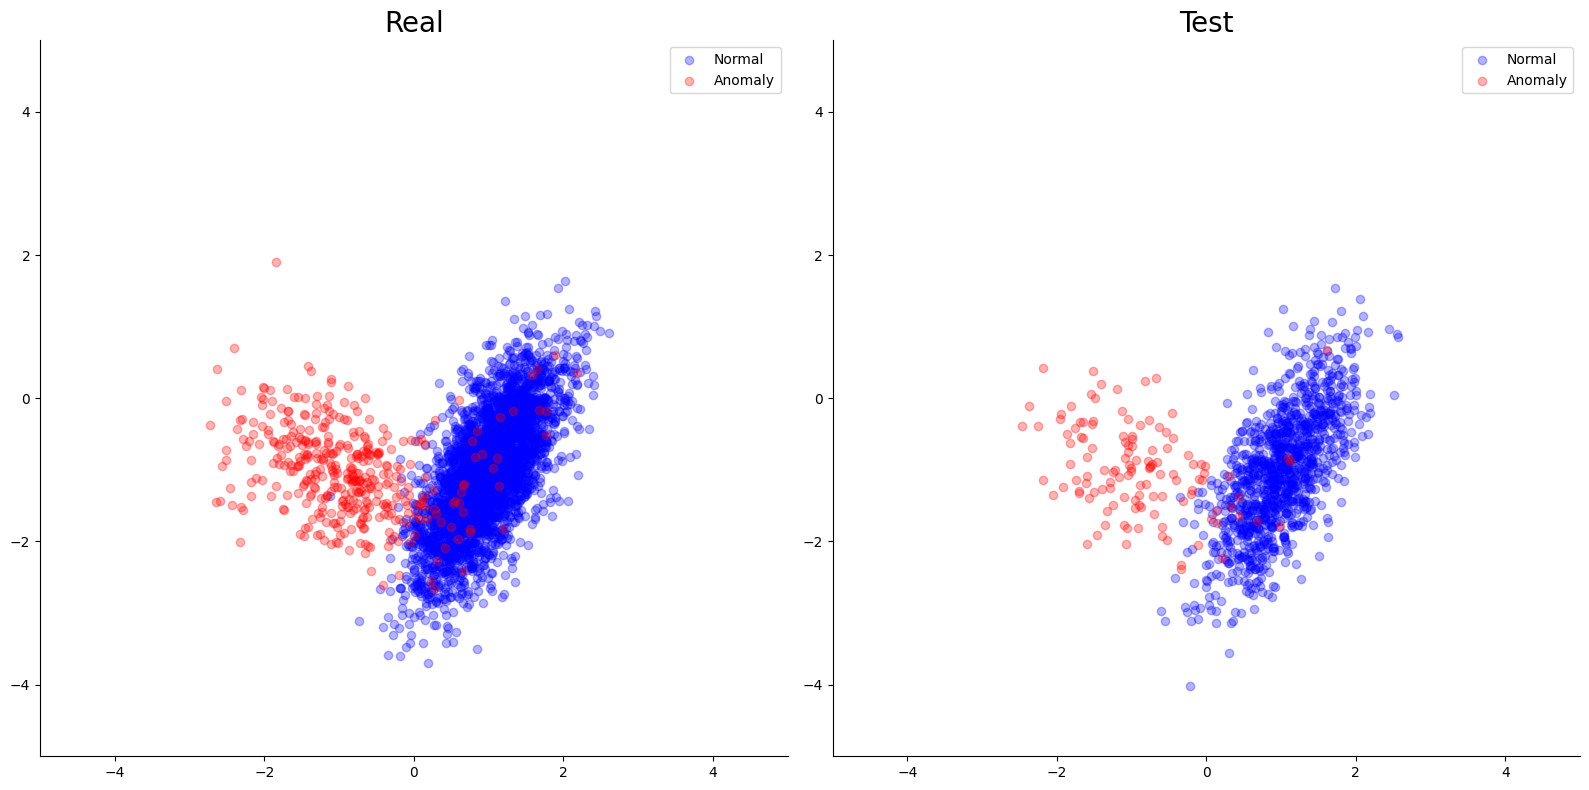

In [8]:
plot_representation(X_train, y_train, X_test, y_test, method='Test')

In [9]:
dt_tree = tree.DecisionTreeClassifier(random_state=2022)
dt_tree.fit(X_train, y_train)

y_pred_test = dt_tree.predict(X_test)
cm_baseline = confusion_matrix(y_test, y_pred_test)

In [10]:
cm_baseline

array([[1104,   22],
       [  15,  109]])

In [11]:
print("Recall for anomaly observations in test dataset: %.4f"%(cm_baseline[1, 1]/cm_baseline[1, :].sum()))
print("Precision for anomaly observations in test dataset: %.4f"%(cm_baseline[1, 1]/cm_baseline[:, 1].sum()) )

Recall for anomaly observations in test dataset: 0.8790
Precision for anomaly observations in test dataset: 0.8321


## Random Over Sampling(ROS)

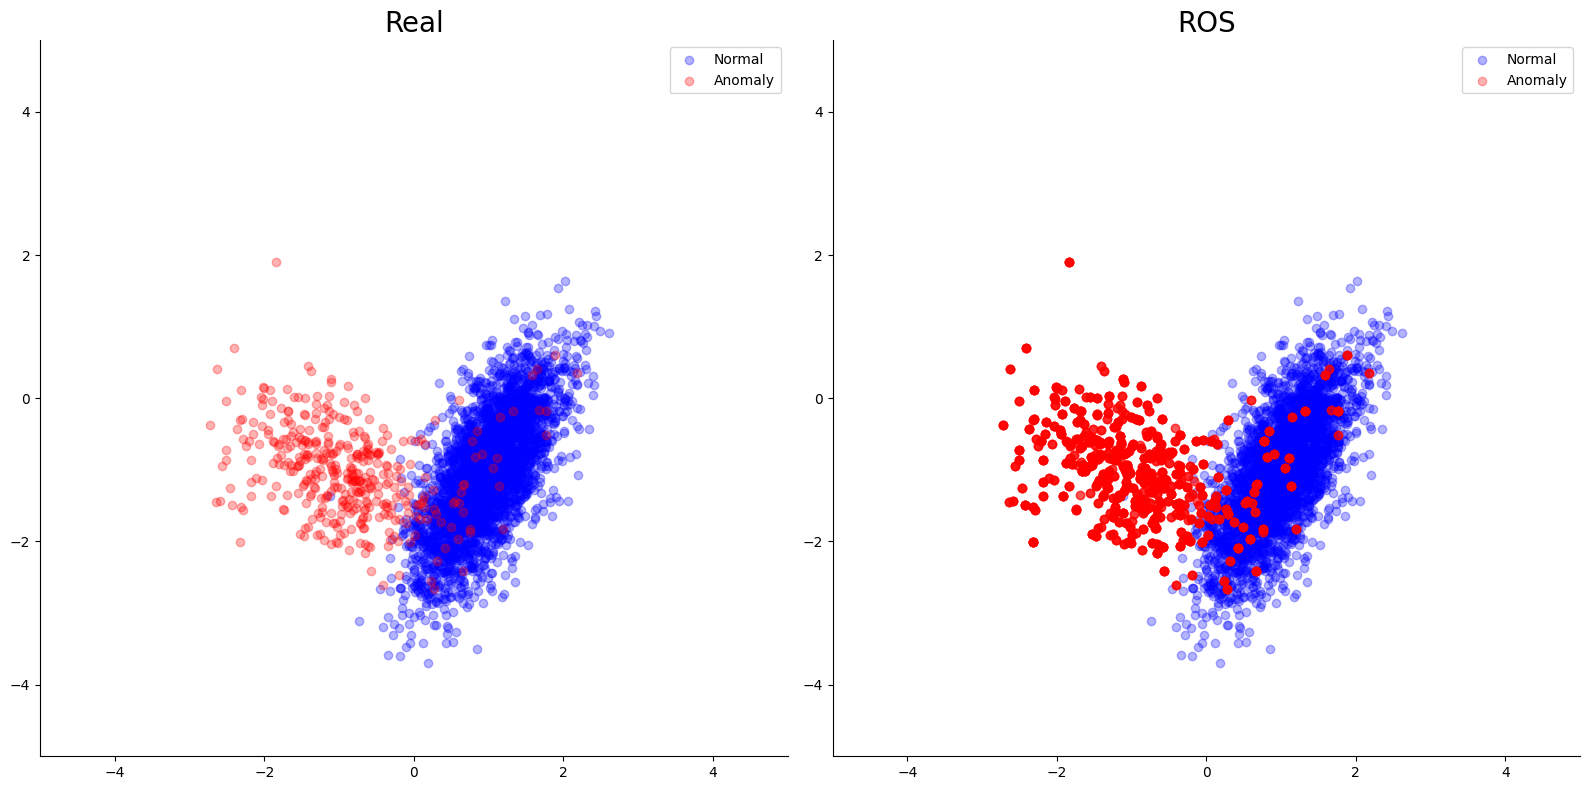

In [12]:
ros = RandomOverSampler()
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

plot_representation(X_train, y_train, X_resampled, y_resampled, 'ROS')

In [13]:
dt_tree = tree.DecisionTreeClassifier(random_state=2022)
ros_tree = dt_tree.fit(X_resampled, y_resampled)

y_pred_test = ros_tree.predict(X_test)
cm_ros = confusion_matrix(y_test, y_pred_test)

In [14]:
cm_ros

array([[1102,   24],
       [  17,  107]])

In [15]:
print("Recall for abnormal data in test dataset: %.4f"%(cm_ros[1, 1]/cm_ros[1, :].sum()))
print("Precision for abnormal data in test dataset: %.4f"%(cm_ros[1, 1]/cm_ros[:, 1].sum()) )

Recall for abnormal data in test dataset: 0.8629
Precision for abnormal data in test dataset: 0.8168


## SMOTE

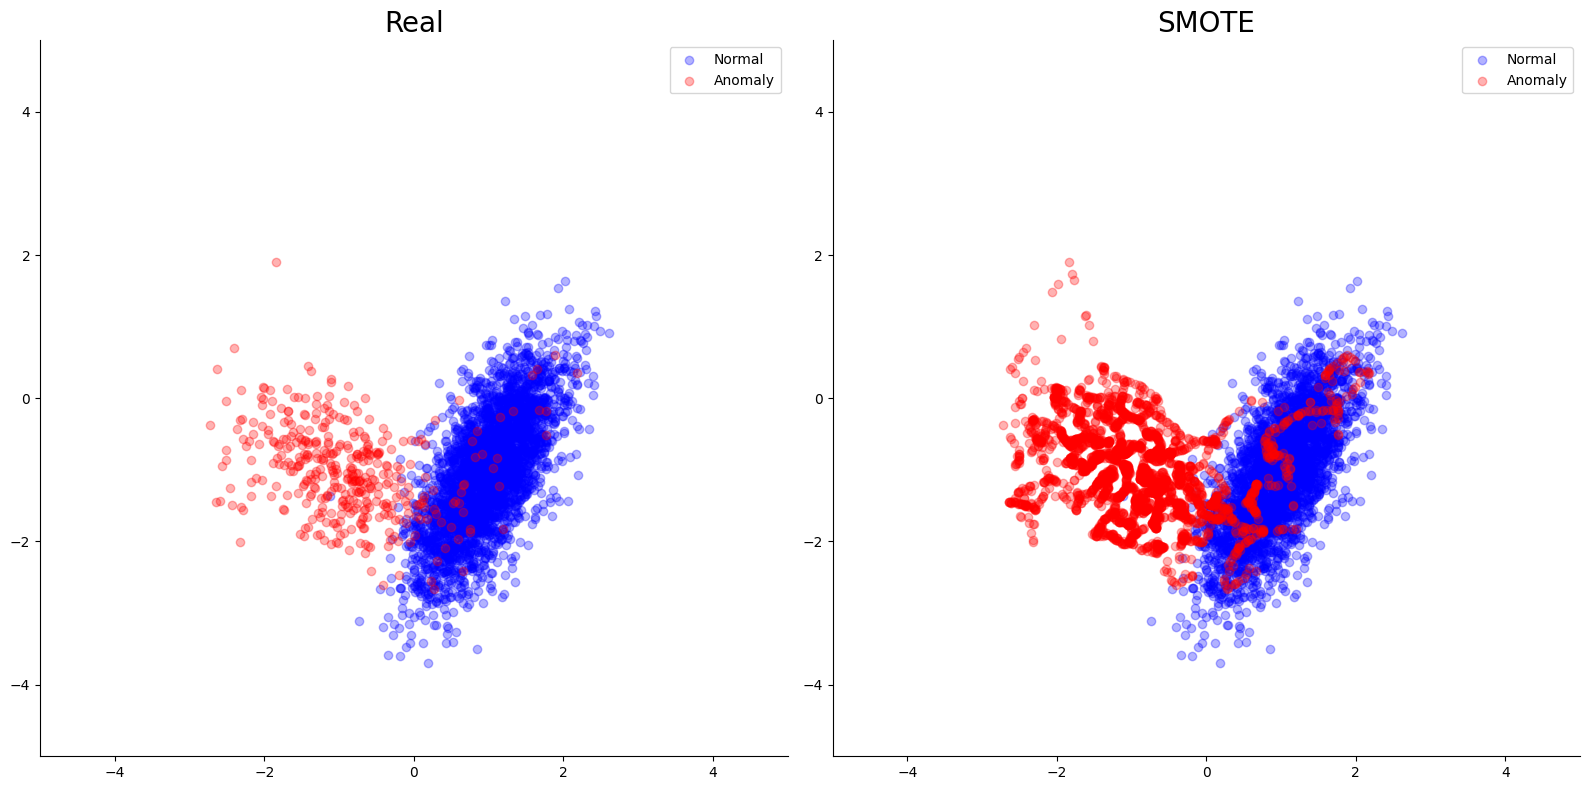

In [16]:
smote = SMOTE(k_neighbors=5)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

plot_representation(X_train, y_train, X_resampled, y_resampled, 'SMOTE')

In [17]:
dt_tree = tree.DecisionTreeClassifier(random_state=2022)
smote_tree = dt_tree.fit(X_resampled, y_resampled)

y_pred_test = smote_tree.predict(X_test)
cm_smote = confusion_matrix(y_test, y_pred_test)

In [18]:
cm_smote

array([[1061,   65],
       [  15,  109]])

In [19]:
print("Recall for abnormal data in test dataset: %.4f"%(cm_smote[1, 1]/cm_smote[1, :].sum()))
print("Precision for abnormal data in test dataset: %.4f"%(cm_smote[1, 1]/cm_smote[:, 1].sum()) )

Recall for abnormal data in test dataset: 0.8790
Precision for abnormal data in test dataset: 0.6264


## Borderline-SMOTE

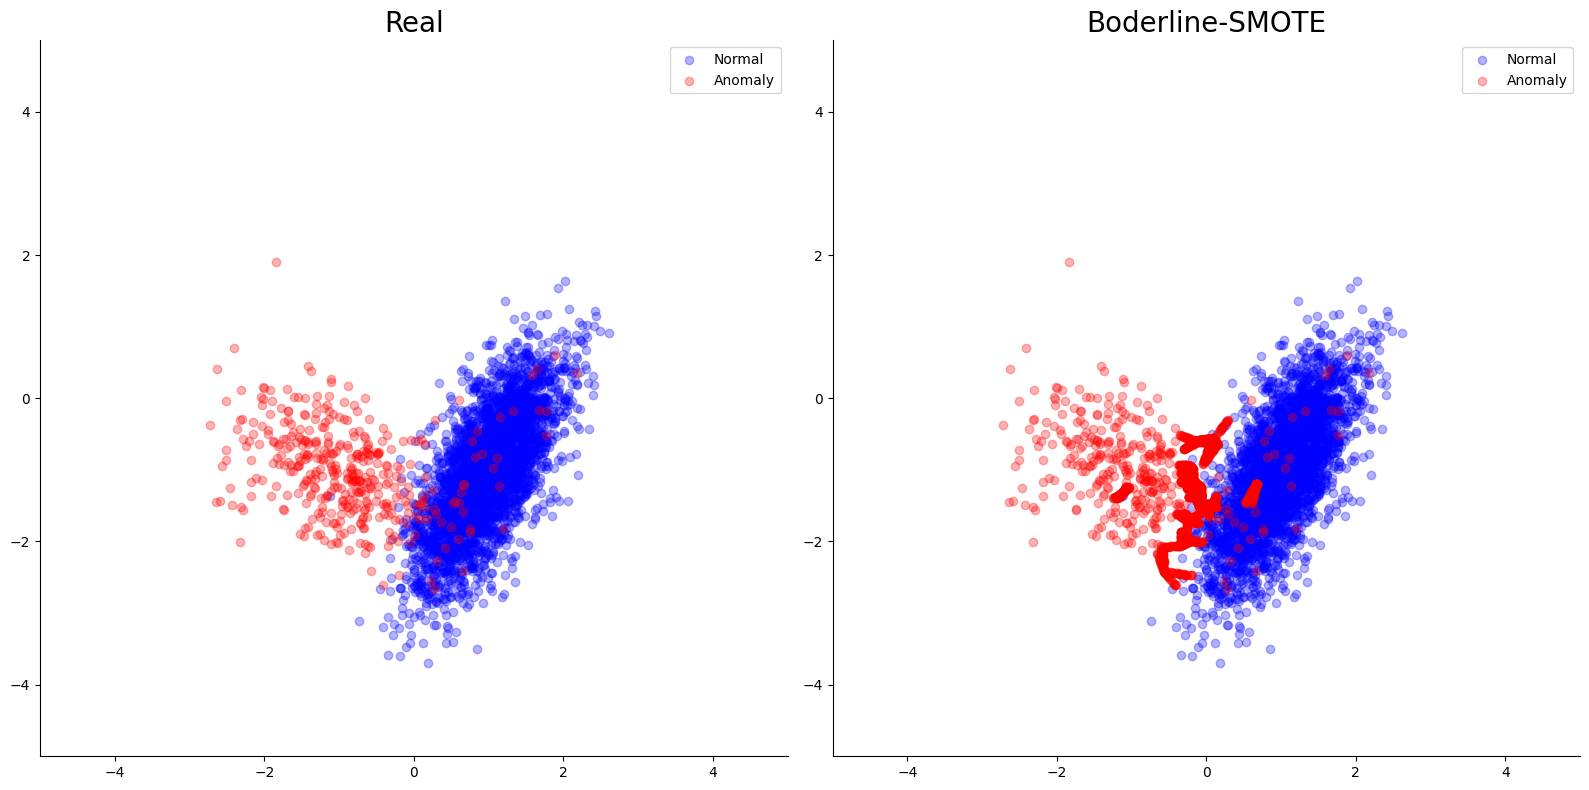

In [20]:
bl_smote = BorderlineSMOTE(k_neighbors=5, m_neighbors=2)
X_resampled, y_resampled = bl_smote.fit_resample(X_train, y_train)

plot_representation(X_train, y_train, X_resampled, y_resampled, 'Boderline-SMOTE')

In [21]:
dt_tree = tree.DecisionTreeClassifier(random_state=2022)
blsmote_tree = dt_tree.fit(X_resampled, y_resampled)

y_pred_test = blsmote_tree.predict(X_test)
cm_blsmote = confusion_matrix(y_test, y_pred_test)

In [22]:
cm_blsmote

array([[1104,   22],
       [  16,  108]])

In [23]:
print("Recall for abnormal data in test dataset: %.4f"%(cm_blsmote[1, 1]/cm_blsmote[1, :].sum()))
print("Precision for abnormal data in test dataset: %.4f"%(cm_blsmote[1, 1]/cm_blsmote[:, 1].sum()) )

Recall for abnormal data in test dataset: 0.8710
Precision for abnormal data in test dataset: 0.8308


## ADASYN

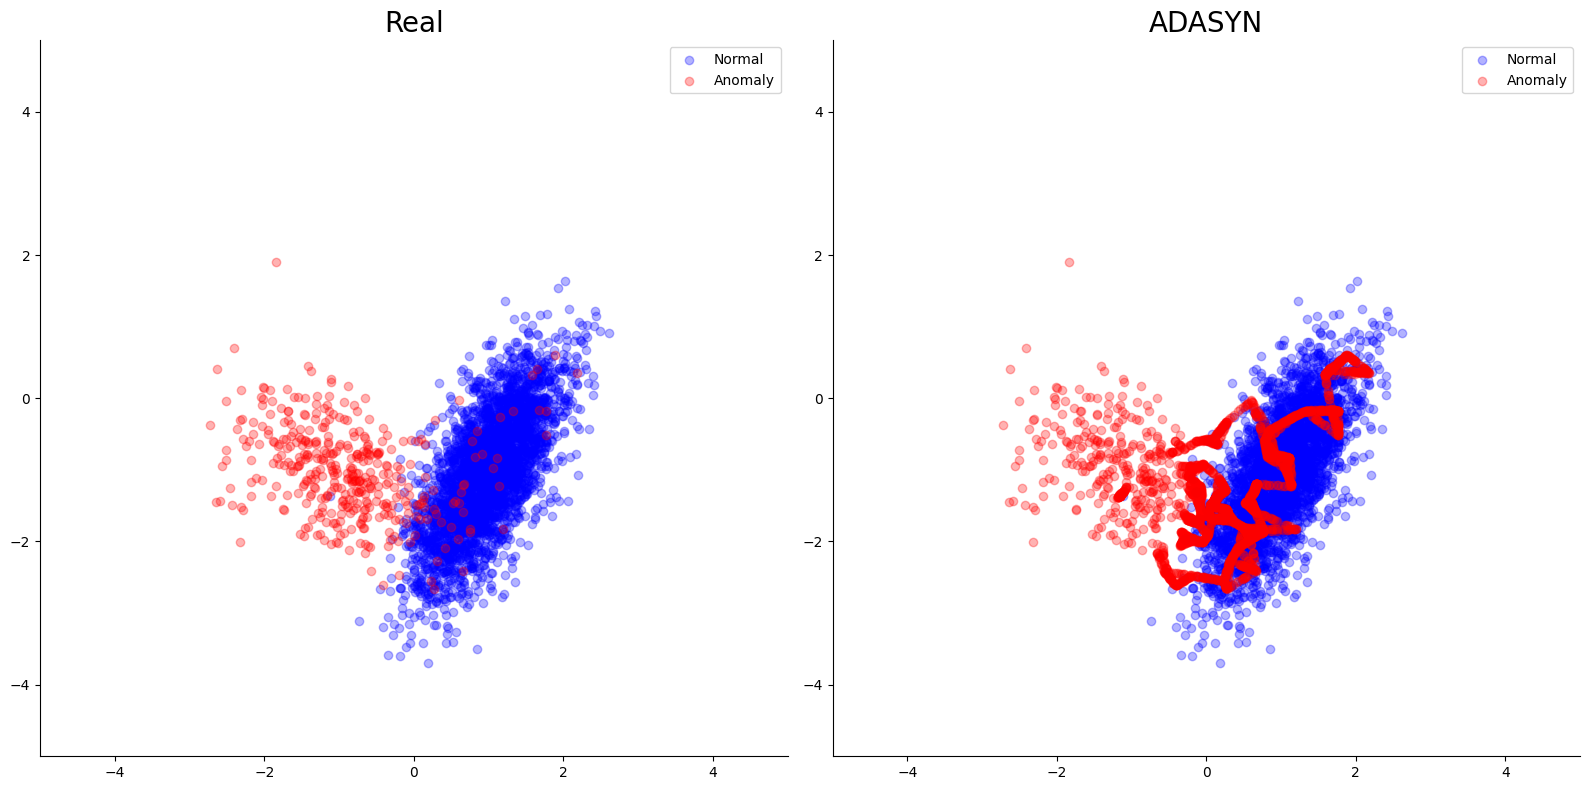

In [24]:
adasyn = ADASYN(n_neighbors=3)
X_resampled, y_resampled = adasyn.fit_resample(X_train, y_train)

plot_representation(X_train, y_train, X_resampled, y_resampled, 'ADASYN')

In [25]:
dt_tree = tree.DecisionTreeClassifier(random_state=2022)
adasyn_tree = dt_tree.fit(X_resampled, y_resampled)

y_pred_test = adasyn_tree.predict(X_test)
cm_adasyn = confusion_matrix(y_test, y_pred_test)

In [26]:
cm_adasyn

array([[1011,  115],
       [  11,  113]])

In [27]:
print("Recall for abnormal data in test dataset: %.4f"%(cm_adasyn[1, 1]/cm_adasyn[1, :].sum()))
print("Precision for abnormal data in test dataset: %.4f"%(cm_adasyn[1, 1]/cm_adasyn[:, 1].sum()) )

Recall for abnormal data in test dataset: 0.9113
Precision for abnormal data in test dataset: 0.4956
